# Quantifying uncertainty in spatial estimates: Custom loss functions in Spatialize's precision module

The Spatialize library includes pre-defined loss functions and allows for custom alternatives. This document covers the latter.

> For an in-depth introduction to the Spatialize precision module check {doc}`this document <../esi_fundamentals/esi_precision>`

## Calculating the precision of ESI estimates with custom loss functions

In [ ]:
# Libraries

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Importar ESI desde repositorio, no desde instalación python, borrar antes de publicar!!
import sys
sys.path.append('../')
import import_helper
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

import numpy as np

# for ESI estimations
from spatialize.gs.esi import esi_hparams_search, esi_nongriddata

# for ESI precision estimations
import spatialize.gs.esi.lossfunction as lf

# for custom precision estimations
from spatialize.gs.esi.aggfunction import mean
from spatialize.gs.esi.lossfunction import loss

# for plots
import matplotlib.pyplot as plt
from spatialize.viz import PlotStyle

# example dataset:
from spatialize.data import load_drill_holes_andes_2D
samples, _, _, _ = load_drill_holes_andes_2D()

### Preparing the inputs
For this example, we'll use an integrated dataset from the Spatialize library.

We'll define the model inputs from the loaded samples:

In [3]:
# Locations of the sample data:
points = samples[['x', 'y']].values

# Values of the sample data:
values = samples[['cu']].values[:, 0]

# Locations to be estimated:
xmin, xmax = points[:,0].min(), points[:,0].max()
ymin, ymax = points[:,1].min(), points[:,1].max()

x_values = np.arange(xmin, xmax + 1, 2)
y_values = np.arange(ymin, ymax + 1,  2)

xi = np.array([(x, y) for x in x_values for y in y_values])

### Obtaining ESI estimates

Next, we'll use the esi_hparams_search function to find optimal parameters for ESI:

In [4]:
search_result = esi_hparams_search(points, values, xi,
                                   local_interpolator="idw",
                                   griddata=False,
                                   k=-1,
                                   p_process="mondrian",
                                   n_partitions=[300],
                                   exponent=[0.1, 0.5, 1, 2, 3, 4],
                                   alpha=(0.7, 0.8, 0.9),
                                   seed=1500)

finished 100% of 18 iterations ... 

done (elapsed time: 25s)


Then, we'll use the esi_nongriddata function to produce estimations for all target points:

In [5]:
esi = esi_nongriddata(points, values, xi,
                      local_interpolator="idw",
                      n_partitions=300,
                      best_params_found=search_result.best_result())

est = esi.estimation()

finished 100% of 300 iterations ... 

done (elapsed time: 28s)


The final estimation looks like this:

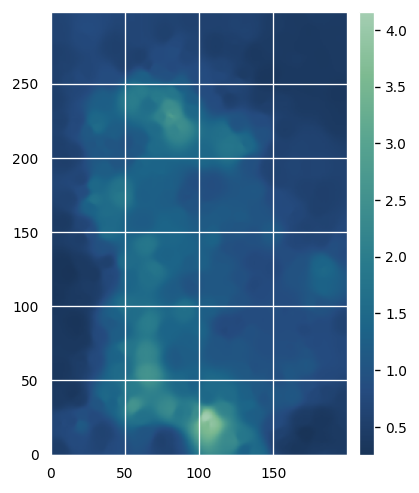

In [6]:
esi.plot_estimation(theme='darkgrid')
plt.show()

### Calculating Precision

First, we'll define a custom loss function. We'll use the mean squared logarithmic error as example:

In [ ]:
# Custom precision function declaration

@loss(mean)
def msle_loss(esi_samples, estimation):
    """
    Calculate Mean Squared Logarithmic Error (MSLE) loss. 
    The @loss(mean) decorator averages the individual
    squared logaritmic error calculations.
    """
    return (np.log(estimation + 1) - np.log(esi_samples + 1)) ** 2


We can then use our custom function in the same way as the built-in functions:

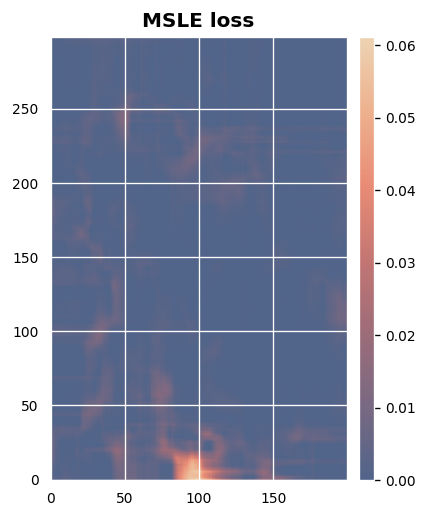

In [8]:
# Using the custom precision function
esi.precision(msle_loss)
esi.plot_precision(theme='darkgrid', title='MSLE loss')
plt.show()